In [13]:
from time import time
from typing import Callable, Dict, Optional, Set

import numpy as np
import onnx
import torch
from onnx import ModelProto
from torch.nn import Linear
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, PretrainedConfig, T5ForConditionalGeneration, TensorType
from transformers.generation_utils import GenerationMixin
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, Seq2SeqLMOutput
from transformers.models.t5.modeling_t5 import T5Stack

from transformer_deploy.backends.ort_utils import create_model_for_provider, inference_onnx_binding, optimize_onnx
from transformer_deploy.backends.pytorch_utils import convert_to_onnx
import onnx
from onnx import GraphProto, ModelProto, helper

# Loading Hugging Face model / tokenizer

We use a specific branch of OnnxRuntime with a better management of if/else/then ONNX node:

```shell
git clone --recursive https://github.com/Microsoft/onnxruntime
cd onnxruntime
git fetch origin hari/location_plan_implicit_inputs
git checkout -b hari/location_plan_implicit_inputs FETCH_HEAD
CUDACXX=/usr/local/cuda-11.4/bin/nvcc ./build.sh \
    --config Release \
    --build_wheel \
    --parallel \
    --use_cuda \
    --cuda_home /usr/local/cuda-11.4 \
    --cudnn_home /usr/lib/x86_
    -linux-gnu/ \
    --skip_test
```

> to clear previous compilation, delete content of `./build` folder

In [14]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_ids: torch.Tensor = tokenizer("Studies show that", return_tensors=TensorType.PYTORCH).input_ids
input_ids = input_ids.to("cuda")
model: T5ForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = model.eval()
model = model.to("cuda")
model.config.use_cache = True
out_enc: BaseModelOutputWithPastAndCrossAttentions = model.encoder(input_ids=input_ids)
out_full: Seq2SeqLMOutput = model(input_ids=input_ids, decoder_input_ids=input_ids)


def are_equal(a: torch.Tensor, b: torch.Tensor, atol: float = 1e-2) -> None:
    assert np.allclose(a=a.detach().cpu().numpy(), b=b.detach().cpu().numpy(), atol=1e-2), f"{a}\n\nVS\n\n{b}"

# Export to ONNX

## Export encoder part

In [15]:
model = model.to("cuda")

convert_to_onnx(
    model_pytorch=model.encoder,
    output_path="test-enc.onnx",
    inputs_pytorch={"input_ids": input_ids},
    var_output_seq=True,
    quantization=False,
)
optimize_onnx(
    onnx_path="test-enc.onnx", onnx_optim_model_path="test-enc-opt.onnx", architecture="bert", use_cuda=True, fp16=True
)

enc_onnx = create_model_for_provider("test-enc-opt.onnx", "CUDAExecutionProvider")
enc_onnx_out = inference_onnx_binding(
    model_onnx=enc_onnx,
    inputs={"input_ids": input_ids},
    device=input_ids.device.type,
    output_shape=tuple(input_ids.shape) + (int(model.encoder.config.d_model),),
)["output"]

are_equal(a=enc_onnx_out, b=out_enc.last_hidden_state)

## Export decoder

### Wrapper to include some post processing on the decoder output

The post processing is mainly a projection of the decoder output on a matrix with one of its dimension equal to model vocabulary size, so we have scores for each possible token.

In [16]:
from typing import Tuple


class ExportT5(torch.nn.Module):
    def __init__(self, decoder: T5Stack, lm_head: Linear):
        super(ExportT5, self).__init__()
        self.decoder = decoder
        self.lm_head = lm_head

    def forward(self, input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, past_key_values: Tuple = None):
        out_dec = self.decoder.forward(
            input_ids=input_ids, encoder_hidden_states=encoder_hidden_states, past_key_values=past_key_values
        )
        # Rescale output before projecting on vocab
        out_dec["last_hidden_state"] = out_dec["last_hidden_state"] * (model.model_dim**-0.5)
        out_dec["last_hidden_state"] = self.lm_head(out_dec["last_hidden_state"])
        return out_dec


model.cuda()
model_decoder = ExportT5(decoder=model.decoder, lm_head=model.lm_head).eval()
out_model_export: torch.Tensor = model_decoder(input_ids=input_ids, encoder_hidden_states=out_enc.last_hidden_state)

are_equal(a=out_model_export["last_hidden_state"], b=out_full.logits)

### Export decoder part to ONNX

Export 2 versions of the decoder, one without cache support and one with it.
Both models share most of their weights.

In [17]:
model_decoder.cuda()
# decoder output one step before
out_dec_pytorch = model_decoder(input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc.last_hidden_state)

model_inputs = {
    "input_ids": input_ids[:, -1:].type(torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
    "past_key_values": out_dec_pytorch.past_key_values,
}

# TODO replace hard coded axis names by generated one when generation works as expected
input_names = [
    "input_ids",
    "encoder_hidden_states",
    "past_key_values.0.decoder.key",
    "past_key_values.0.decoder.value",
    "past_key_values.0.encoder.key",
    "past_key_values.0.encoder.value",
    "past_key_values.1.decoder.key",
    "past_key_values.1.decoder.value",
    "past_key_values.1.encoder.key",
    "past_key_values.1.encoder.value",
    "past_key_values.2.decoder.key",
    "past_key_values.2.decoder.value",
    "past_key_values.2.encoder.key",
    "past_key_values.2.encoder.value",
    "past_key_values.3.decoder.key",
    "past_key_values.3.decoder.value",
    "past_key_values.3.encoder.key",
    "past_key_values.3.encoder.value",
    "past_key_values.4.decoder.key",
    "past_key_values.4.decoder.value",
    "past_key_values.4.encoder.key",
    "past_key_values.4.encoder.value",
    "past_key_values.5.decoder.key",
    "past_key_values.5.decoder.value",
    "past_key_values.5.encoder.key",
    "past_key_values.5.encoder.value",
]

output_names = [
    "logits",
    "present.0.decoder.key",
    "present.0.decoder.value",
    "present.0.encoder.key",
    "present.0.encoder.value",
    "present.1.decoder.key",
    "present.1.decoder.value",
    "present.1.encoder.key",
    "present.1.encoder.value",
    "present.2.decoder.key",
    "present.2.decoder.value",
    "present.2.encoder.key",
    "present.2.encoder.value",
    "present.3.decoder.key",
    "present.3.decoder.value",
    "present.3.encoder.key",
    "present.3.encoder.value",
    "present.4.decoder.key",
    "present.4.decoder.value",
    "present.4.encoder.key",
    "present.4.encoder.value",
    "present.5.decoder.key",
    "present.5.decoder.value",
    "present.5.encoder.key",
    "present.5.encoder.value",
]

dynamic_axis = {
    "input_ids": {0: "batch", 1: "encoder_sequence"},
    "encoder_hidden_states": {0: "batch", 1: "encoder_sequence"},
    "past_key_values.0.decoder.key": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.0.decoder.value": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.0.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.0.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.1.decoder.key": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.1.decoder.value": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.1.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.1.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.2.decoder.key": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.2.decoder.value": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.2.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.2.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.3.decoder.key": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.3.decoder.value": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.3.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.3.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.4.decoder.key": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.4.decoder.value": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.4.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.4.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.5.decoder.key": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.5.decoder.value": {0: "batch", 2: "past_decoder_sequence"},
    "past_key_values.5.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "past_key_values.5.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "logits": {0: "batch", 1: "decoder_sequence"},
    "present.0.decoder.key": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.0.decoder.value": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.0.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "present.0.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "present.1.decoder.key": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.1.decoder.value": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.1.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "present.1.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "present.2.decoder.key": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.2.decoder.value": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.2.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "present.2.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "present.3.decoder.key": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.3.decoder.value": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.3.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "present.3.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "present.4.decoder.key": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.4.decoder.value": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.4.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "present.4.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
    "present.5.decoder.key": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.5.decoder.value": {0: "batch", 2: "past_decoder_sequence + sequence"},
    "present.5.encoder.key": {0: "batch", 2: "past_encoder_sequence"},
    "present.5.encoder.value": {0: "batch", 2: "past_encoder_sequence"},
}

with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs,),
        f="test-dec-cache.onnx",
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axis,
        do_constant_folding=True,
        opset_version=13,
    )

model_inputs_no_cache = {
    "input_ids": input_ids.type(torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
}

with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs_no_cache,),
        f="test-dec-no-cache.onnx",
        input_names=list(model_inputs_no_cache.keys()),
        output_names=output_names,
        dynamic_axes={k: v for k, v in dynamic_axis.items() if "past_key_values" not in k},
        do_constant_folding=True,
        opset_version=13,
    )

In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode


### Merge ONNX computation graph to deduplicate weights

TODO remove unecessary initializer to avoid warning messages

In [18]:
onnx_model_cache = onnx.load("test-dec-cache.onnx")
onnx_model_no_cache = onnx.load("test-dec-no-cache.onnx")

prefix = "cache_node_"
mapping_initializer_cache_to_no_cache = dict()
to_add = list()
for node_cache in onnx_model_cache.graph.initializer:
    found = False
    for node_no_cache in onnx_model_no_cache.graph.initializer:
        if node_cache.raw_data == node_no_cache.raw_data:
            found = True
            mapping_initializer_cache_to_no_cache[node_cache.name] = node_no_cache.name
            break
    if not found:
        node_cache.name = prefix + node_cache.name
        to_add.append(node_cache)
        mapping_initializer_cache_to_no_cache[node_cache.name] = node_cache.name
        print(f"name: {node_cache.name} - size: {len(node_cache.raw_data)/1024:.2f}")

onnx_model_no_cache.graph.initializer.extend(to_add)
# I/O model names should not be prefixed
model_io_names = [n.name for n in list(onnx_model_cache.graph.input) + list(onnx_model_cache.graph.output)]

for node in onnx_model_cache.graph.node:
    for index, input_name in enumerate(node.input):
        if input_name in model_io_names:
            continue
        node.input[index] = mapping_initializer_cache_to_no_cache.get(input_name, prefix + input_name)
    for index, output_name in enumerate(node.output):
        if output_name in model_io_names:
            continue
        node.output[index] = prefix + output_name
    node.name = prefix + node.name
model_io_names = [n.name for n in list(onnx_model_cache.graph.input) + list(onnx_model_cache.graph.output)]

prefix = "init_"
cache = dict()
for node in onnx_model_no_cache.graph.initializer:
    if node.name in model_io_names:
        new_name = prefix + node.name
        cache[node.name] = new_name
        node.name = new_name

for node in onnx_model_no_cache.graph.node:
    for index, n in enumerate(node.input):
        node.input[index] = cache.get(n, n)

# mandatory for subgraph in if/else node
assert len(onnx_model_cache.graph.output) == len(onnx_model_no_cache.graph.output)

graph_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_cache.graph.node),
    name="graph-cache",
    inputs=[],
    outputs=list(onnx_model_cache.graph.output),
    initializer=[],
)

graph_no_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_no_cache.graph.node),
    name="graph-no-cache",
    inputs=[],
    outputs=list(onnx_model_no_cache.graph.output),
    initializer=[],
)

enable_cache_input = onnx.helper.make_tensor_value_info(name="enable_cache", elem_type=onnx.TensorProto.BOOL, shape=[1])

if_node = onnx.helper.make_node(
    op_type="If",
    inputs=["enable_cache"],
    outputs=[o.name for o in list(onnx_model_no_cache.graph.output)],
    then_branch=graph_cache,
    else_branch=graph_no_cache,
)

if_graph_def: GraphProto = helper.make_graph(
    nodes=[if_node],
    name="if-model",
    inputs=list(onnx_model_cache.graph.input) + [enable_cache_input],
    outputs=list(onnx_model_no_cache.graph.output),
    initializer=list(onnx_model_no_cache.graph.initializer),
)


model_def: ModelProto = helper.make_model(
    if_graph_def, producer_name="onnx-example", opset_imports=[helper.make_opsetid(onnx.defs.ONNX_DOMAIN, 13)]
)
onnx.checker.check_model(model_def)

name: cache_node_onnx::Slice_1256 - size: 0.01
name: cache_node_onnx::Slice_1257 - size: 0.01
name: cache_node_onnx::Slice_1267 - size: 0.01
name: cache_node_onnx::Slice_1268 - size: 0.01


### Check ONNX decoder output

Compare ONNX output with and without cache, plus compare with Pytorch output.

In [19]:
model = model.cuda()
model_decoder = model_decoder.cuda()
input_ids = input_ids.cuda()
model = model.eval()
model_decoder = model_decoder.eval()
enc_onnx = create_model_for_provider("test-enc-opt.onnx", "CUDAExecutionProvider")
dec_onnx = create_model_for_provider(model_def.SerializeToString(), "CUDAExecutionProvider")

2022-04-29 17:45:00.319750016 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_1221'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.319768049 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_1154'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.319772884 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_1003'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.319776918 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_919'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.319786543 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_1070'. It is 

## Benchmark new model on real scenario

TODO: print graph of cache / no cache latency for each seq len + show how to justify what we measure
TODO: convert the model to FP16 + add some explanation regarding aggressive conversion https://pytorch.org/docs/stable/amp.html?utm_source=pocket_mylist
TODO: add experiment with TensorRT in mixed precision
TODO: try https://github.com/microsoft/onnxruntime/pull/11320 + https://github.com/microsoft/onnxruntime/pull/8702 + https://github.com/microsoft/onnxruntime/issues/11254

In [20]:
with torch.inference_mode():
    out_enc_pytorch: BaseModelOutputWithPastAndCrossAttentions = model.encoder(input_ids=input_ids)
    previous_step_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )
    out_dec_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids, encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )

 used by any node and should be removed from the model.
2022-04-29 17:45:00.412604626 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Pow_359'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.412609494 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Pow_611'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.412612623 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Add_849'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.412615827 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Pow_443'. It is not used by any node and should be removed from the model.
2022-04-29 17:45:00.412619244 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Rem

In [21]:
def decoder_pytorch_inference(decoder_input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, **_):
    with torch.inference_mode():
        return model_decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_hidden_states)


def decoder_onnx_inference(
    decoder_input_ids: torch.Tensor,
    encoder_hidden_states: torch.Tensor,
    enable_cache: torch.Tensor,
    past_key_values: Optional[torch.Tensor],
):
    inputs_onnx_dict = {
        "input_ids": decoder_input_ids,
        "encoder_hidden_states": encoder_hidden_states,
        "enable_cache": enable_cache,
    }

    if past_key_values is not None:
        for index, (k_dec, v_dec, k_enc, v_enc) in enumerate(past_key_values):
            inputs_onnx_dict[f"past_key_values.{index}.decoder.key"] = k_dec
            inputs_onnx_dict[f"past_key_values.{index}.decoder.value"] = v_dec
            inputs_onnx_dict[f"past_key_values.{index}.encoder.key"] = k_enc
            inputs_onnx_dict[f"past_key_values.{index}.encoder.value"] = v_enc

    output_shape = {"logits": tuple(decoder_input_ids.shape) + (int(model.config.vocab_size),)}
    enc_batch, enc_seq_len, _ = encoder_hidden_states.shape
    if past_key_values is None:
        dec_batch, dec_seq_len = decoder_input_ids.shape
    else:
        # dec_batch, _ = decoder_input_ids.shape
        # seq len can't be guessed from input_ids which is always 1
        dec_batch, _, dec_seq_len, _ = past_key_values[0][0].shape
        dec_seq_len += 1

    for i in range(int(model.config.num_layers)):
        output_shape[f"present.{i}.decoder.key"] = (
            int(dec_batch),
            int(model.config.num_heads),
            int(dec_seq_len),
            int(model.config.d_kv),
        )
        output_shape[f"present.{i}.decoder.value"] = (
            int(dec_batch),
            int(model.config.num_heads),
            int(dec_seq_len),
            int(model.config.d_kv),
        )
        output_shape[f"present.{i}.encoder.key"] = (
            int(dec_batch),
            int(model.config.num_heads),
            int(enc_seq_len),
            int(model.config.d_kv),
        )
        output_shape[f"present.{i}.encoder.value"] = (
            int(dec_batch),
            int(model.config.num_heads),
            int(enc_seq_len),
            int(model.config.d_kv),
        )
    result_dict = inference_onnx_binding(
        model_onnx=dec_onnx,
        inputs=inputs_onnx_dict,
        device=decoder_input_ids.device.type,
        output_shape=output_shape,
    )
    past_states = list()
    for i in range(model.config.num_layers):
        kv = (
            result_dict[f"present.{i}.decoder.key"],
            result_dict[f"present.{i}.decoder.value"],
            result_dict[f"present.{i}.encoder.key"],
            result_dict[f"present.{i}.encoder.value"],
        )
        past_states.append(kv)
    torch.cuda.synchronize()
    return BaseModelOutputWithPastAndCrossAttentions(
        last_hidden_state=result_dict["logits"],
        past_key_values=past_states,
    )


out_dec_onnx_no_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids,
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([False], device="cuda", dtype=torch.bool),
    past_key_values=None,
)
are_equal(a=out_dec_onnx_no_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_no_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_no_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [22]:
out_dec_onnx_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids[:, -1:],
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([True], device="cuda", dtype=torch.bool),
    past_key_values=previous_step_pytorch.past_key_values,
)

are_equal(a=out_dec_onnx_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [23]:
def encoder_onnx_inference(input_ids: torch.Tensor, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    last_hidden_state = inference_onnx_binding(
        model_onnx=enc_onnx,  # noqa: F821
        inputs={"input_ids": input_ids},
        output_shape=tuple(input_ids.shape) + (int(model.encoder.config.d_model),),
        device=input_ids.device.type,
    )["output"]
    return BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=last_hidden_state)


def encoder_pytorch_inference(input_ids, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    with torch.inference_mode():
        res = model.encoder(input_ids=input_ids)
        return res


# https://github.com/NVIDIA/TensorRT/blob/main/demo/HuggingFace/T5/export.py
class ExtT5(torch.nn.Module, GenerationMixin):
    def __init__(self, config: PretrainedConfig, device: torch.device, encoder_func: Callable, decoder_func: Callable):
        super(ExtT5, self).__init__()
        self.main_input_name = "input_ids"  # https://github.com/huggingface/transformers/pull/14803
        self.config: PretrainedConfig = config
        self.device: torch.device = device

        self.encoder_func = encoder_func
        self.decoder_func = decoder_func
        self.use_cache = True
        self.timings = list()

    def get_encoder(self):
        return self.encoder_func

    def get_decoder(self):
        return self.decoder_func

    def set_cache(self, enable: bool) -> None:
        self.use_cache = enable

    # from transformers library (modeling_t5.py)
    def _reorder_cache(self, past, beam_idx):
        reordered_decoder_past = ()
        for layer_past_states in past:
            # get the correct batch idx from layer past batch dim
            # batch dim of `past` is at 2nd position
            reordered_layer_past_states = ()
            for layer_past_state in layer_past_states:
                # need to set correct `past` for each of the four key / value states
                reordered_layer_past_states = reordered_layer_past_states + (
                    layer_past_state.index_select(0, beam_idx),
                )

            assert reordered_layer_past_states[0].shape == layer_past_states[0].shape
            assert len(reordered_layer_past_states) == len(layer_past_states)

            reordered_decoder_past = reordered_decoder_past + (reordered_layer_past_states,)
        return reordered_decoder_past

    def prepare_inputs_for_generation(self, input_ids, past=None, use_cache=None, **kwargs) -> Dict[str, torch.Tensor]:
        params = {
            "encoder_hidden_states": kwargs["encoder_outputs"]["last_hidden_state"],
        }
        if past is None:  # this is the 1st inferred token
            self.timings = list()
        if not self.use_cache:
            past = None
        if past is None:
            params[self.main_input_name] = input_ids
            params["enable_cache"] = torch.tensor([False], device="cuda", dtype=torch.bool)
        else:
            params[self.main_input_name] = input_ids[:, -1:]
            params["enable_cache"] = torch.tensor([True], device="cuda", dtype=torch.bool)
            params["past_key_values"] = past

        return params

    def forward(
        self,
        input_ids: torch.Tensor,
        encoder_hidden_states: torch.Tensor,
        enable_cache: torch.Tensor,
        past_key_values: Optional[torch.Tensor] = None,
        **_,
    ):
        start_timer = time()
        dec_output = self.get_decoder()(
            decoder_input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            enable_cache=enable_cache,
            past_key_values=past_key_values,
        )
        self.timings.append(time() - start_timer)
        return Seq2SeqLMOutput(logits=dec_output.last_hidden_state, past_key_values=dec_output.past_key_values)


model_gen = (
    ExtT5(
        config=model.config,
        device=model.device,
        encoder_func=encoder_onnx_inference,  # encoder_pytorch_inference
        decoder_func=decoder_onnx_inference,  # decoder_pytorch_inference
    )
    .cuda()
    .eval()
)

torch.cuda.synchronize()
with torch.inference_mode():
    print(
        tokenizer.decode(
            model_gen.generate(
                inputs=input_ids,
                decoder_input_ids=input_ids,
                min_length=30,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=False,
        )
    )
    print(
        tokenizer.decode(
            model.generate(
                input_ids=input_ids,
                decoder_input_ids=input_ids,
                min_length=30,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=False,
        )
    )

Studies show that</s>.. ; studies studies show, :; –;; (;);;.; études -</s>
Studies show that</s>.. ; studies studies show, :; –;; (;);;.; études -</s>


In [24]:
from copy import copy

model_gen.set_cache(enable=False)
start = time()
model_gen.generate(inputs=input_ids, max_length=2000, num_beams=4, min_length=2000)
print(f"ONNX: {time() - start}")
model_gen.set_cache(enable=True)
timing_onnx_no_cache = model_gen.timings

model_gen.set_cache(enable=True)
start = time()
model_gen.generate(inputs=input_ids, max_length=2000, num_beams=4, min_length=2000)
print(f"ONNX + cache: {time() - start}")
timing_onnx_cache = model_gen.timings

# monckey patching of forward function to add a timer per generated token
old_fw = model.forward
timing_pytorch = list()


def new_fw(self, *args, **kwargs):
    timer_start = time()
    res = old_fw(self, *args, **kwargs)
    torch.cuda.synchronize()  # makes timings correct without having significant impact on e2e latency
    timing_pytorch.append(time() - timer_start)
    return res


model.forward = new_fw.__get__(model)

model.config.use_cache = False
with torch.inference_mode():
    with torch.cuda.amp.autocast():
        start = time()
        model.generate(inputs=input_ids, max_length=2000, num_beams=4, min_length=2000)
        torch.cuda.synchronize()
        print(f"Pytorch: {time() - start}")

timing_pytorch_no_cache = copy(timing_pytorch)
timing_pytorch.clear()

model.config.use_cache = True
with torch.inference_mode():
    with torch.cuda.amp.autocast():
        start = time()
        model.generate(inputs=input_ids, max_length=2000, num_beams=4, min_length=2000)
        torch.cuda.synchronize()
        print(f"Pytorch + cache: {time() - start}")
timing_pytorch_cache = copy(timing_pytorch)
timing_pytorch.clear()
model.forward = old_fw

ONNX: 61.09446406364441
ONNX + cache: 10.958698511123657
Pytorch: 67.91197490692139
Pytorch + cache: 15.910704612731934


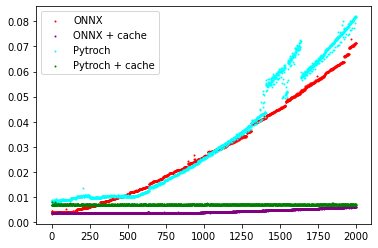

In [25]:
import matplotlib.pylab as plt

axis = range(len(timing_onnx_no_cache))
plt.scatter(axis, timing_onnx_no_cache, marker="o", color="red", label="ONNX", s=1)
plt.scatter(axis, timing_onnx_cache, marker="o", color="purple", label="ONNX + cache", s=1)
plt.scatter(axis, timing_pytorch_no_cache, marker="o", color="cyan", label="Pytroch", s=1)
plt.scatter(axis, timing_pytorch_cache, marker="o", color="green", label="Pytroch + cache", s=1)
plt.legend()

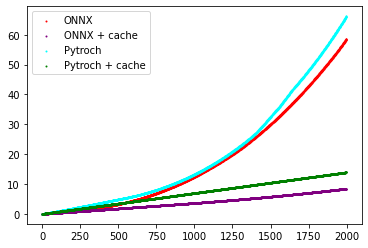

In [26]:
axis = range(len(timing_onnx_no_cache))
plt.scatter(axis, np.cumsum(timing_onnx_no_cache), marker="o", color="red", label="ONNX", s=1)
plt.scatter(axis, np.cumsum(timing_onnx_cache), marker="o", color="purple", label="ONNX + cache", s=1)
plt.scatter(axis, np.cumsum(timing_pytorch_no_cache), marker="o", color="cyan", label="Pytroch", s=1)
plt.scatter(axis, np.cumsum(timing_pytorch_cache), marker="o", color="green", label="Pytroch + cache", s=1)
plt.legend()

# TODO change axis name to better describe what they are, in particular manage encoder and decoder models with common names


link to https://github.com/microsoft/onnxruntime/pull/10651 !

In [27]:
# trt_logger: Logger = trt.Logger(trt.Logger.ERROR)
# runtime: Runtime = trt.Runtime(trt_logger)
# trt_model_name = "trt-t5-dec.plan"
#
# # create only of does not exist because it's slow to run...
#
# # 768 for base model, 512 for small, make it dependent from the Pytorch model configuration
# input_id_shape = TensorRTShape(min_shape=[5, 1], optimal_shape=[5, 500], max_shape=[5, 500], input_name="input_ids")
# encoder_hidden_states_shape = TensorRTShape(
#     min_shape=[5, 1, 512], optimal_shape=[5, 500 // 2, 512], max_shape=[5, 500, 512], input_name="encoder_hidden_states"
# )
#
#
# model = model.cuda()
# model_onnx: ModelProto = onnx.load("test-dec.onnx")
# model_onnx_all_nodes = add_output_nodes(model=model_onnx)
# onnx_graph: Dict[str, Set[str]] = get_adjency_dict(model=model_onnx)
# ort_model_all_nodes = create_model_for_provider(model_onnx_all_nodes.SerializeToString(), "CUDAExecutionProvider")
#
#
# # use info from tokenizer size and max shape provided through the command line
# def get_random_input():
#     input = torch.randint(high=tokenizer.vocab_size, size=(5, 500), dtype=torch.int32, device="cuda")
#     hidden_state = model.encoder(input_ids=input).last_hidden_state.detach().cpu().numpy()
#     return {"input_ids": input.detach().cpu().numpy(), "encoder_hidden_states": hidden_state}
#
#
# keep_fp32 = get_list_fp32_nodes(
#     onnx_graph=onnx_graph, model=ort_model_all_nodes, get_input=get_random_input, nb_try=200
# )
# model = model.cpu()

In [28]:
# engine: ICudaEngine = build_engine(
#     runtime=runtime,
#     onnx_file_path="test-dec.onnx",
#     logger=trt_logger,
#     workspace_size=20000 * 1024**2,
#     fp16=True,
#     int8=False,
#     input_shapes=[input_id_shape, encoder_hidden_states_shape],
#     fp16_fix=get_fix_fp16_network_func(keep_fp32=keep_fp32),
# )
# save_engine(engine, trt_model_name)
#
# tensorrt_model = load_engine(runtime=runtime, engine_file_path=trt_model_name)
# a = tensorrt_model(
#     {
#         "input_ids": input_ids.type(torch.int32).repeat((5, 1)),
#         "encoder_hidden_states": out_enc.last_hidden_state.repeat((5, 1, 1)),
#     }
# )
# print(a[0])
#
# benchmark_input = torch.ones((5, 500), dtype=torch.int32, device="cuda")
# benchmark_enc_output = out_enc.last_hidden_state.repeat((5, 1, 1))
# for _ in range(10):
#     tensorrt_model(
#         {
#             "input_ids": benchmark_input,
#             "encoder_hidden_states": benchmark_enc_output,
#         }
#     )
# start = time()
# for _ in range(100):
#     tensorrt_model(
#         {
#             "input_ids": benchmark_input,
#             "encoder_hidden_states": benchmark_enc_output,
#         }
#     )
# print(time() - start)
#
# dec_onnx = create_model_for_provider("test-dec-opt.onnx", "CUDAExecutionProvider")
# dec_onnx_out = decoder_onnx_inference(input_ids=input_ids, last_hidden_state=out_enc.last_hidden_state)
#
#
# for _ in range(10):
#     decoder_onnx_inference(input_ids=benchmark_input, last_hidden_state=benchmark_enc_output)
# start = time()
# for _ in range(100):
#     decoder_onnx_inference(input_ids=benchmark_input, last_hidden_state=benchmark_enc_output)
# print(time() - start)
#
# model.cuda()
# for _ in range(10):
#     model.decoder(input_ids=benchmark_input, encoder_hidden_states=benchmark_enc_output)
# start = time()
# for _ in range(100):
#     model.decoder(input_ids=benchmark_input, encoder_hidden_states=benchmark_enc_output)
# print(time() - start)

# TensorRT, ONNX Runtime, Pytorch

# sequence 500
# 0.8640644550323486
# 0.6695075035095215
# 1.1308434009552002

# sequence 250
# 0.9177014827728271
# 0.6861860752105713
# 1.1923034191131592